## Imports

In [1]:
#inporting packages
#from sci378 import *
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import itertools
import warnings

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score, roc_curve, auc, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix


In [2]:
from google.colab import files
upload = files.upload()

Saving stackoverflow_full.csv to stackoverflow_full (4).csv


In [3]:
#loading in dataset
df = pd.read_csv("stackoverflow_full.csv")
df.head(2)

,Unnamed: 0,Age,Accessibility,EdLevel,Employment,Gender,MentalHealth,MainBranch,YearsCode,YearsCodePro,Country,PreviousSalary,HaveWorkedWith,ComputerSkills,Employed
0,0,<35,No,Master,1,Man,No,Dev,7,4,Sweden,51552.0,C++;Python;Git;PostgreSQL,4,0
1,1,<35,No,Undergraduate,1,Man,No,Dev,12,5,Spain,46482.0,Bash/Shell;HTML/CSS;JavaScript;Node.js;SQL;Typ...,12,1


## Data cleaning

In [4]:
#checking feature types
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73462 entries, 0 to 73461
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Unnamed: 0      73462 non-null  int64  
 1   Age             73462 non-null  object 
 2   Accessibility   73462 non-null  object 
 3   EdLevel         73462 non-null  object 
 4   Employment      73462 non-null  int64  
 5   Gender          73462 non-null  object 
 6   MentalHealth    73462 non-null  object 
 7   MainBranch      73462 non-null  object 
 8   YearsCode       73462 non-null  int64  
 9   YearsCodePro    73462 non-null  int64  
 10  Country         73462 non-null  object 
 11  PreviousSalary  73462 non-null  float64
 12  HaveWorkedWith  73399 non-null  object 
 13  ComputerSkills  73462 non-null  int64  
 14  Employed        73462 non-null  int64  
dtypes: float64(1), int64(6), object(8)
memory usage: 8.4+ MB


In [5]:
#checking for null values
df.isnull().sum()

Unnamed: 0         0
Age                0
Accessibility      0
EdLevel            0
Employment         0
Gender             0
MentalHealth       0
MainBranch         0
YearsCode          0
YearsCodePro       0
Country            0
PreviousSalary     0
HaveWorkedWith    63
ComputerSkills     0
Employed           0
dtype: int64

In [6]:
#getting column names
df.columns

Index(['Unnamed: 0', 'Age', 'Accessibility', 'EdLevel', 'Employment', 'Gender',
       'MentalHealth', 'MainBranch', 'YearsCode', 'YearsCodePro', 'Country',
       'PreviousSalary', 'HaveWorkedWith', 'ComputerSkills', 'Employed'],
      dtype='object')

In [7]:
#dropping first column because it has no significant meaning
df = df.drop(['Unnamed: 0'], axis=1)
df.head(2)

,Age,Accessibility,EdLevel,Employment,Gender,MentalHealth,MainBranch,YearsCode,YearsCodePro,Country,PreviousSalary,HaveWorkedWith,ComputerSkills,Employed
0,<35,No,Master,1,Man,No,Dev,7,4,Sweden,51552.0,C++;Python;Git;PostgreSQL,4,0
1,<35,No,Undergraduate,1,Man,No,Dev,12,5,Spain,46482.0,Bash/Shell;HTML/CSS;JavaScript;Node.js;SQL;Typ...,12,1


In [8]:
# replacing null values to unknown
df['HaveWorkedWith'] = df['HaveWorkedWith'].replace([np.nan], ['Unknown'])


In [9]:
# splitting HaveWorkedWith column into rows by the ; delimeter
df = df.assign(HaveWorkedWith = df['HaveWorkedWith'].str.split(';')).explode('HaveWorkedWith')
df = df.reset_index(level = 0)

In [10]:
# find the top 10 skills that job applicants worked with
top10_skills=df['HaveWorkedWith'].value_counts().sort_values(ascending = False)
top10_skills.head(10)

JavaScript    49347
Docker        40224
HTML/CSS      40207
SQL           38361
Git           35911
AWS           31590
Python        31159
PostgreSQL    30102
MySQL         29490
TypeScript    27533
Name: HaveWorkedWith, dtype: int64

In [11]:
# making the column HaveWorkedWith all lower case
df['HaveWorkedWith'] = df['HaveWorkedWith'].str.lower()

In [12]:
# replacing sql to SQL and git to GIT for not confusion in the function below
df['HaveWorkedWith'].replace('sql', 'SQL', inplace=True)
df['HaveWorkedWith'].replace('git', 'GIT', inplace=True)


In [13]:
# finding the top 10 skills (lowercase)
a = df['HaveWorkedWith'].value_counts().sort_values(ascending = False)
a.head(10)

javascript    49347
docker        40224
html/css      40207
SQL           38361
GIT           35911
aws           31590
python        31159
postgresql    30102
mysql         29490
typescript    27533
Name: HaveWorkedWith, dtype: int64

In [14]:
df.columns

Index(['index', 'Age', 'Accessibility', 'EdLevel', 'Employment', 'Gender',
       'MentalHealth', 'MainBranch', 'YearsCode', 'YearsCodePro', 'Country',
       'PreviousSalary', 'HaveWorkedWith', 'ComputerSkills', 'Employed'],
      dtype='object')

In [15]:
# reverse exploding/splitting the columns to get back to the original data frame
df = (df.groupby(['index', 'Age', 'Accessibility', 'EdLevel', 'Employment', 'Gender','MentalHealth', 'MainBranch', 'YearsCode', 'YearsCodePro', 'Country','PreviousSalary', 'ComputerSkills', 'Employed']).agg({'HaveWorkedWith': lambda x: ";".join(x)}).reset_index())

In [16]:
#Top 1 skill as a feature
def JavaScript(HaveWorkedWith):
    if isinstance(HaveWorkedWith, str):
        if any(keyword in HaveWorkedWith for keyword in ['javascript']):
           return 1
        else:
           return 0
    else:
        return None
df['JavaScript'] = df['HaveWorkedWith'].apply(JavaScript)

#Top 2 skill as a feature
def Docker(HaveWorkedWith):
    if isinstance(HaveWorkedWith, str):
        if any(keyword in HaveWorkedWith for keyword in ['docker']):
            return 1
        else:
            return 0
    else:
        return None
df['Docker'] = df['HaveWorkedWith'].apply(Docker)

#Top 3 skill as a feature
def HTML_CSS(HaveWorkedWith):
    if isinstance(HaveWorkedWith, str):
        if any(keyword in HaveWorkedWith for keyword in ['html/css']):
           return 1
        else:
           return 0
    else:
        return None
df['HTML_CSS'] = df['HaveWorkedWith'].apply(HTML_CSS)

#Top 4 skill as a feature
def SQL(HaveWorkedWith):
    if isinstance(HaveWorkedWith, str):
        if any(keyword in HaveWorkedWith for keyword in ['SQL']):
           return 1
        else:
           return 0
    else:
        return None
df['SQL'] = df['HaveWorkedWith'].apply(SQL)

#Top 5 skill as a feature
def Git(HaveWorkedWith):
    if isinstance(HaveWorkedWith, str):
        if any(keyword in HaveWorkedWith for keyword in ['GIT']):
           return 1
        else:
           return 0
    else:
        return None
df['Git'] = df['HaveWorkedWith'].apply(Git)

#Top 6 skill as a feature
def AWS(HaveWorkedWith):
    if isinstance(HaveWorkedWith, str):
        if any(keyword in HaveWorkedWith for keyword in ['aws']):
           return 1
        else:
           return 0
    else:
        return None
df['AWS'] = df['HaveWorkedWith'].apply(AWS)

#Top 7 skill as a feature
def Python(HaveWorkedWith):
    if isinstance(HaveWorkedWith, str):
        if any(keyword in HaveWorkedWith for keyword in ['python']):
           return 1
        else:
           return 0
    else:
        return None
df['Python'] = df['HaveWorkedWith'].apply(Python)

#Top 8 skill as a feature
def PostgreSQL(HaveWorkedWith):
    if isinstance(HaveWorkedWith, str):
        if any(keyword in HaveWorkedWith for keyword in ['postgresql']):
           return 1
        else:
           return 0
    else:
        return None
df['PostgreSQL'] = df['HaveWorkedWith'].apply(PostgreSQL)

#Top 9 skill as a feature
def MySQL(HaveWorkedWith):
    if isinstance(HaveWorkedWith, str):
        if any(keyword in HaveWorkedWith for keyword in ['mysql']):
           return 1
        else:
           return 0
    else:
        return None
df['MySQL'] = df['HaveWorkedWith'].apply(MySQL)

#Top 10 skill as a feature
def TypeScript(HaveWorkedWith):
    if isinstance(HaveWorkedWith, str):
        if any(keyword in HaveWorkedWith for keyword in ['typescript']):
           return 1
        else:
           return 0
    else:
        return None
df['TypeScript'] = df['HaveWorkedWith'].apply(TypeScript)

In [17]:
df.head(2)

,index,Age,Accessibility,EdLevel,Employment,Gender,MentalHealth,MainBranch,YearsCode,YearsCodePro,...,JavaScript,Docker,HTML_CSS,SQL,Git,AWS,Python,PostgreSQL,MySQL,TypeScript
0,0,<35,No,Master,1,Man,No,Dev,7,4,...,0,0,0,0,1,0,1,1,0,0
1,1,<35,No,Undergraduate,1,Man,No,Dev,12,5,...,1,0,1,1,1,1,0,1,0,1


In [18]:
df = df.drop(['index'], axis=1)
df.head(2)

,Age,Accessibility,EdLevel,Employment,Gender,MentalHealth,MainBranch,YearsCode,YearsCodePro,Country,...,JavaScript,Docker,HTML_CSS,SQL,Git,AWS,Python,PostgreSQL,MySQL,TypeScript
0,<35,No,Master,1,Man,No,Dev,7,4,Sweden,...,0,0,0,0,1,0,1,1,0,0
1,<35,No,Undergraduate,1,Man,No,Dev,12,5,Spain,...,1,0,1,1,1,1,0,1,0,1


In [19]:
#dropping HaveWorkedWith - coding abilities are accounted for in the ComputerSkills feature
df = df.drop(['HaveWorkedWith'], axis=1)
df.head(2)

,Age,Accessibility,EdLevel,Employment,Gender,MentalHealth,MainBranch,YearsCode,YearsCodePro,Country,...,JavaScript,Docker,HTML_CSS,SQL,Git,AWS,Python,PostgreSQL,MySQL,TypeScript
0,<35,No,Master,1,Man,No,Dev,7,4,Sweden,...,0,0,0,0,1,0,1,1,0,0
1,<35,No,Undergraduate,1,Man,No,Dev,12,5,Spain,...,1,0,1,1,1,1,0,1,0,1


In [20]:
#adding continent feature to group country
country_to_continent = {
'United States of America': 'North America', 'Germany': 'Europe', 'India': 'Asia', 'United Kingdom of Great Britain and Northern Ireland': 'Europe',
    'Canada': 'North America', 'France': 'Europe', 'Brazil': 'South America', 'Poland': 'Europe',
    'Netherlands': 'Europe', 'Spain': 'Europe', 'Australia': 'Oceania', 'Italy': 'Europe', 'Sweden': 'Europe',
    'Russian Federation': 'Europe', 'Switzerland': 'Europe', 'Turkey': 'Europe', 'Austria': 'Europe', 'Israel': 'Asia',
    'Czech Republic': 'Europe', 'Mexico': 'North America', 'Belgium': 'Europe', 'Denmark': 'Europe', 'Ukraine': 'Europe',
    'Norway': 'Europe', 'Argentina': 'South America', 'Iran, Islamic Republic of...': 'Asia', 'Finland': 'Europe',
    'South Africa': 'Africa', 'Pakistan': 'Asia', 'Portugal': 'Europe', 'Romania': 'Europe', 'Greece': 'Europe',
    'New Zealand': 'Oceania', 'Hungary': 'Europe', 'Colombia': 'South America', 'Bangladesh': 'Asia', 'Japan': 'Asia',
    'Bulgaria': 'Europe', 'China': 'Asia', 'Indonesia': 'Asia', 'Ireland': 'Europe', 'Slovenia': 'Europe', 'Nigeria': 'Africa',
    'Serbia': 'Europe', 'Egypt': 'Africa', 'Philippines': 'Asia', 'Sri Lanka': 'Asia', 'Chile': 'South America',
    'Croatia': 'Europe', 'Lithuania': 'Europe', 'Taiwan': 'Asia', 'Singapore': 'Asia', 'Malaysia': 'Asia', 'Slovakia': 'Europe',
    'Viet Nam': 'Asia', 'Kenya': 'Africa', 'Estonia': 'Europe', 'Uruguay': 'South America', 'Nepal': 'Asia', 'Belarus': 'Europe',
    'Thailand': 'Asia', 'Hong Kong (S.A.R.)': 'Asia', 'Peru': 'South America', 'South Korea': 'Asia',
    'United Arab Emirates': 'Asia', 'Georgia': 'Asia', 'Venezuela, Bolivarian Republic of...': 'South America',
    'Dominican Republic': 'North America', 'Morocco': 'Africa', 'Latvia': 'Europe', 'Ecuador': 'South America',
    'Bosnia and Herzegovina': 'Europe', 'Costa Rica': 'North America', 'Armenia': 'Asia', 'Tunisia': 'Africa',
    'Saudi Arabia': 'Asia', 'Guatemala': 'North America', 'Kazakhstan': 'Asia', 'Paraguay': 'South America',
    'Albania': 'Europe', 'Ghana': 'Africa', 'Luxembourg': 'Europe', 'The former Yugoslav Republic of Macedonia': 'Europe',
    'Lebanon': 'Asia', 'Jordan': 'Asia', 'Ethiopia': 'Africa', 'Cyprus': 'Europe', 'Azerbaijan': 'Asia',
    'Republic of Korea': 'Asia', 'Bolivia': 'South America', 'Uganda': 'Africa', 'Republic of Moldova': 'Europe',
    'Uzbekistan': 'Asia', 'Malta': 'Europe', 'Cuba': 'North America', 'Iceland': 'Europe', 'El Salvador': 'North America',
    'Panama': 'North America', 'United Republic of Tanzania': 'Africa', 'Syrian Arab Republic': 'Asia', 'Myanmar': 'Asia',
    'Iraq': 'Asia', 'Honduras': 'North America', 'Kosovo': 'Europe', 'Nomadic': 'Unknown', 'Mauritius': 'Africa',
    'Cameroon': 'Africa', 'Palestine': 'Asia', 'Montenegro': 'Europe', 'Sudan': 'Africa', 'Algeria': 'Africa',
    'Zimbabwe': 'Africa', 'Nicaragua': 'North America', 'Rwanda': 'Africa', 'Kuwait': 'Asia', 'Cambodia': 'Asia',
    'Madagascar': 'Africa', 'Kyrgyzstan': 'Asia', 'Afghanistan': 'Asia', "Côte d'Ivoire": 'Africa', 'Mongolia': 'Asia',
    'Jamaica': 'North America', 'Trinidad and Tobago': 'North America', 'Zambia': 'Africa', 'Senegal': 'Africa',
    'Andorra': 'Europe', 'Maldives': 'Asia', 'Bahrain': 'Asia', 'Qatar': 'Asia', 'Namibia': 'Africa', 'Benin': 'Africa',
    'Turkmenistan': 'Asia', 'Yemen': 'Asia', 'Democratic Republic of the Congo': 'Africa', 'Angola': 'Africa',
    'Oman': 'Asia', 'Congo, Republic of the...': 'Africa', 'Botswana': 'Africa', 'Mozambique': 'Africa',
    'Tajikistan': 'Asia', 'Malawi': 'Africa', 'Barbados': 'North America', 'Isle of Man': 'Europe',
    'Guyana': 'South America', 'Swaziland': 'Africa', 'Togo': 'Africa', 'Libyan Arab Jamahiriya': 'Africa',
    "Lao People's Democratic Republic": 'Asia', 'Somalia': 'Africa', 'Lesotho': 'Africa', 'Suriname': 'South America',
    'Mali': 'Africa', 'Bhutan': 'Asia', 'Belize': 'North America', 'Guinea': 'Africa', 'Cape Verde': 'Africa',
    'Haiti': 'North America', 'Fiji': 'Oceania', 'Timor-Leste': 'Asia', 'Saint Lucia': 'North America', 'Niger': 'Africa',
    'Djibouti': 'Africa', 'Liberia': 'Africa', 'Monaco': 'Europe', 'Saint Kitts and Nevis': 'North America',
    'Gambia': 'Africa', 'Seychelles': 'Africa', 'Burkina Faso': 'Africa', 'Saint Vincent and the Grenadines': 'North America',
    'Burundi': 'Africa', 'Dominica': 'North America', 'Mauritania': 'Africa'

}

df['Continent'] = df['Country'].map(country_to_continent)

df.head()

,Age,Accessibility,EdLevel,Employment,Gender,MentalHealth,MainBranch,YearsCode,YearsCodePro,Country,...,Docker,HTML_CSS,SQL,Git,AWS,Python,PostgreSQL,MySQL,TypeScript,Continent
0,<35,No,Master,1,Man,No,Dev,7,4,Sweden,...,0,0,0,1,0,1,1,0,0,Europe
1,<35,No,Undergraduate,1,Man,No,Dev,12,5,Spain,...,0,1,1,1,1,0,1,0,1,Europe
2,<35,No,Master,1,Man,No,Dev,15,6,Germany,...,0,0,0,1,0,0,0,0,0,Europe
3,<35,No,Undergraduate,1,Man,No,Dev,9,6,Canada,...,0,1,1,1,1,0,1,1,0,North America
4,>35,No,PhD,0,Man,No,NotDev,40,30,Singapore,...,0,0,0,0,0,1,0,0,0,Asia


In [21]:
#dropping Country column - when applying one hot encoder we do not want to end up with 170+ features
df = df.drop(['Country'], axis=1)
df.head(2)

,Age,Accessibility,EdLevel,Employment,Gender,MentalHealth,MainBranch,YearsCode,YearsCodePro,PreviousSalary,...,Docker,HTML_CSS,SQL,Git,AWS,Python,PostgreSQL,MySQL,TypeScript,Continent
0,<35,No,Master,1,Man,No,Dev,7,4,51552.0,...,0,0,0,1,0,1,1,0,0,Europe
1,<35,No,Undergraduate,1,Man,No,Dev,12,5,46482.0,...,0,1,1,1,1,0,1,0,1,Europe


In [22]:
# create a table with only the top 10 skills
df_skills = df[['JavaScript', 'Docker','HTML_CSS', 'SQL', 'Git','AWS','Python','PostgreSQL','MySQL','TypeScript']]
df_skills.head(2)

,JavaScript,Docker,HTML_CSS,SQL,Git,AWS,Python,PostgreSQL,MySQL,TypeScript
0,0,0,0,0,1,0,1,1,0,0
1,1,0,1,1,1,1,0,1,0,1


In [23]:
#getting list of names of all the categorical variables
cat_var = df.select_dtypes(include=['object']).columns.tolist()
cat_var

['Age',
 'Accessibility',
 'EdLevel',
 'Gender',
 'MentalHealth',
 'MainBranch',
 'Continent']

In [24]:
#converting list to a categorical dataframe
cat_df = df[cat_var]
cat_df.head(2)

,Age,Accessibility,EdLevel,Gender,MentalHealth,MainBranch,Continent
0,<35,No,Master,Man,No,Dev,Europe
1,<35,No,Undergraduate,Man,No,Dev,Europe


In [25]:
#prepped to use OneHotEncoder
from sklearn.preprocessing import OneHotEncoder

In [26]:
# Perform one-hot encoding - this is stored as an array
encoder = OneHotEncoder(sparse=False)
categorical_encoded = encoder.fit_transform(cat_df)

# creating a dataframe with encoded features
categorical_encoded_df = pd.DataFrame(categorical_encoded,
                                        columns=encoder.get_feature_names_out())

#outputting
categorical_encoded_df.head(2)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


,Age_<35,Age_>35,Accessibility_No,Accessibility_Yes,EdLevel_Master,EdLevel_NoHigherEd,EdLevel_Other,EdLevel_PhD,EdLevel_Undergraduate,Gender_Man,...,MentalHealth_Yes,MainBranch_Dev,MainBranch_NotDev,Continent_Africa,Continent_Asia,Continent_Europe,Continent_North America,Continent_Oceania,Continent_South America,Continent_Unknown
0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [27]:
# gluing together the categorical encoded dataframe and the skills dataframe
categorical_encoded_df = pd.concat([categorical_encoded_df, df_skills], axis=1)
categorical_encoded_df.head(2)

,Age_<35,Age_>35,Accessibility_No,Accessibility_Yes,EdLevel_Master,EdLevel_NoHigherEd,EdLevel_Other,EdLevel_PhD,EdLevel_Undergraduate,Gender_Man,...,JavaScript,Docker,HTML_CSS,SQL,Git,AWS,Python,PostgreSQL,MySQL,TypeScript
0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0,0,0,0,1,0,1,1,0,0
1,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,...,1,0,1,1,1,1,0,1,0,1


In [28]:
categorical_encoded_df.columns

Index(['Age_<35', 'Age_>35', 'Accessibility_No', 'Accessibility_Yes',
       'EdLevel_Master', 'EdLevel_NoHigherEd', 'EdLevel_Other', 'EdLevel_PhD',
       'EdLevel_Undergraduate', 'Gender_Man', 'Gender_NonBinary',
       'Gender_Woman', 'MentalHealth_No', 'MentalHealth_Yes', 'MainBranch_Dev',
       'MainBranch_NotDev', 'Continent_Africa', 'Continent_Asia',
       'Continent_Europe', 'Continent_North America', 'Continent_Oceania',
       'Continent_South America', 'Continent_Unknown', 'JavaScript', 'Docker',
       'HTML_CSS', 'SQL', 'Git', 'AWS', 'Python', 'PostgreSQL', 'MySQL',
       'TypeScript'],
      dtype='object')

In [29]:
#dropping feature to prevent dependencies
categorical_encoded_df = categorical_encoded_df.drop(['Age_>35', 'Accessibility_No','EdLevel_Other','Gender_NonBinary',
                                                     'MentalHealth_No','MainBranch_NotDev','Continent_Unknown'], axis=1)
categorical_encoded_df.head(2)

,Age_<35,Accessibility_Yes,EdLevel_Master,EdLevel_NoHigherEd,EdLevel_PhD,EdLevel_Undergraduate,Gender_Man,Gender_Woman,MentalHealth_Yes,MainBranch_Dev,...,JavaScript,Docker,HTML_CSS,SQL,Git,AWS,Python,PostgreSQL,MySQL,TypeScript
0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0,0,0,0,1,0,1,1,0,0
1,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,...,1,0,1,1,1,1,0,1,0,1


In [30]:
# Drop the original categorical columns from X
df_encoded = df.drop(columns=['Age','Accessibility','EdLevel','Gender','MentalHealth','MainBranch','Continent', 'JavaScript', 'Docker','HTML_CSS', 'SQL', 'Git','AWS','Python','PostgreSQL','MySQL','TypeScript'])

# Concatenate the one-hot encoded categorical variables with the rest of the features
df_encoded = pd.concat([df_encoded,categorical_encoded_df], axis=1)

#viewing dataset
df_encoded.head()

,Employment,YearsCode,YearsCodePro,PreviousSalary,ComputerSkills,Employed,Age_<35,Accessibility_Yes,EdLevel_Master,EdLevel_NoHigherEd,...,JavaScript,Docker,HTML_CSS,SQL,Git,AWS,Python,PostgreSQL,MySQL,TypeScript
0,1,7,4,51552.0,4,0,1.0,0.0,1.0,0.0,...,0,0,0,0,1,0,1,1,0,0
1,1,12,5,46482.0,12,1,1.0,0.0,0.0,0.0,...,1,0,1,1,1,1,0,1,0,1
2,1,15,6,77290.0,7,0,1.0,0.0,1.0,0.0,...,0,0,0,0,1,0,0,0,0,0
3,1,9,6,46135.0,13,0,1.0,0.0,0.0,0.0,...,1,0,1,1,1,1,0,1,1,0
4,0,40,30,160932.0,2,0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,1,0,0,0


## ML Preprossesing

In [31]:
# Establish our target feature, churn, as our y feature
y = df_encoded['Employed']

# Drop our target feature from our features dataframe
X = df_encoded.drop('Employed', axis = 1)

In [32]:
# so far we have created:

# df - contains actual values in dataframe
# df_encoded - is our encoded dataframe
# y - target variable
# X - features encoded

# before any splitting or training,
# pausing to explore trends in the data

In [33]:
X.shape

(73462, 31)

## Data Exploration

In [34]:
df.head(2)

,Age,Accessibility,EdLevel,Employment,Gender,MentalHealth,MainBranch,YearsCode,YearsCodePro,PreviousSalary,...,Docker,HTML_CSS,SQL,Git,AWS,Python,PostgreSQL,MySQL,TypeScript,Continent
0,<35,No,Master,1,Man,No,Dev,7,4,51552.0,...,0,0,0,1,0,1,1,0,0,Europe
1,<35,No,Undergraduate,1,Man,No,Dev,12,5,46482.0,...,0,1,1,1,1,0,1,0,1,Europe


In [35]:
#df.to_csv('df.csv')

In [36]:
#This plot will show what percent of applicants know the corresponding language
def plot_all(df):
    copy = df

    fig = plt.figure(figsize = (40, 15))

    plt.subplot(251)
    plt.pie(copy.JavaScript.value_counts(), labels = ['Yes', 'No'], autopct = '%.1f%%', textprops = {'fontsize':20, 'fontweight':'bold'}, startangle = 90)
    plt.title('JavaScript', fontweight = 'bold', fontsize = 25)

    plt.subplot(252)
    plt.pie(copy.Docker.value_counts(), labels = ['Yes', 'No'], autopct = '%.1f%%', textprops = {'fontsize':20, 'fontweight':'bold'}, startangle = 90)
    plt.title('Docker', fontweight = 'bold', fontsize = 25)

    plt.subplot(253)
    plt.pie(copy.HTML_CSS.value_counts(), labels = ['Yes', 'No'], autopct = '%.1f%%', textprops = {'fontsize':20, 'fontweight':'bold'}, startangle = 90)
    plt.title('HTML_CSS', fontweight = 'bold', fontsize = 25)

    plt.subplot(254)
    plt.pie(copy.SQL.value_counts(), labels = ['Yes', 'No'], autopct = '%.1f%%', textprops = {'fontsize':20, 'fontweight':'bold'}, startangle = 90)
    plt.title('SQL', fontweight = 'bold', fontsize = 25)

    plt.subplot(255)
    plt.pie(copy.Git.value_counts(), labels = ['No', 'Yes'], autopct = '%.1f%%', textprops = {'fontsize':20, 'fontweight':'bold'}, startangle = 90)
    plt.title('Git', fontweight = 'bold', fontsize = 25)

    plt.subplot(256)
    plt.pie(copy.AWS.value_counts(), labels = ['No', 'Yes'], autopct = '%.1f%%', textprops = {'fontsize':20, 'fontweight':'bold'}, startangle = 90)
    plt.title('AWS', fontsize = 25, fontweight = 'bold')

    plt.subplot(257)
    plt.pie(copy.Python.value_counts(), labels = ['No', 'Yes'], autopct = '%.1f%%', textprops = {'fontsize':20, 'fontweight':'bold'}, startangle = 90)
    plt.title('Python', fontsize = 25, fontweight = 'bold')

    plt.subplot(258)
    plt.pie(copy.PostgreSQL.value_counts(), labels = ['No', 'Yes'], autopct = '%.1f%%', textprops = {'fontsize':20, 'fontweight':'bold'}, startangle = 90)
    plt.title('PostgreSQL', fontsize = 25, fontweight = 'bold')

    plt.subplot(2,5,9)
    plt.pie(copy.MySQL.value_counts(), labels = ['No', 'Yes'], autopct = '%.1f%%', textprops = {'fontsize':20, 'fontweight':'bold'}, startangle = 90)
    plt.title('MySQL', fontsize = 25, fontweight = 'bold')

    plt.subplot(2,5,10)
    plt.pie(copy.TypeScript.value_counts(), labels = ['No', 'Yes'], autopct = '%.1f%%', textprops = {'fontsize':20, 'fontweight':'bold'}, startangle = 90)
    plt.title('TypeScript', fontsize = 25, fontweight = 'bold')

    plt.tight_layout()

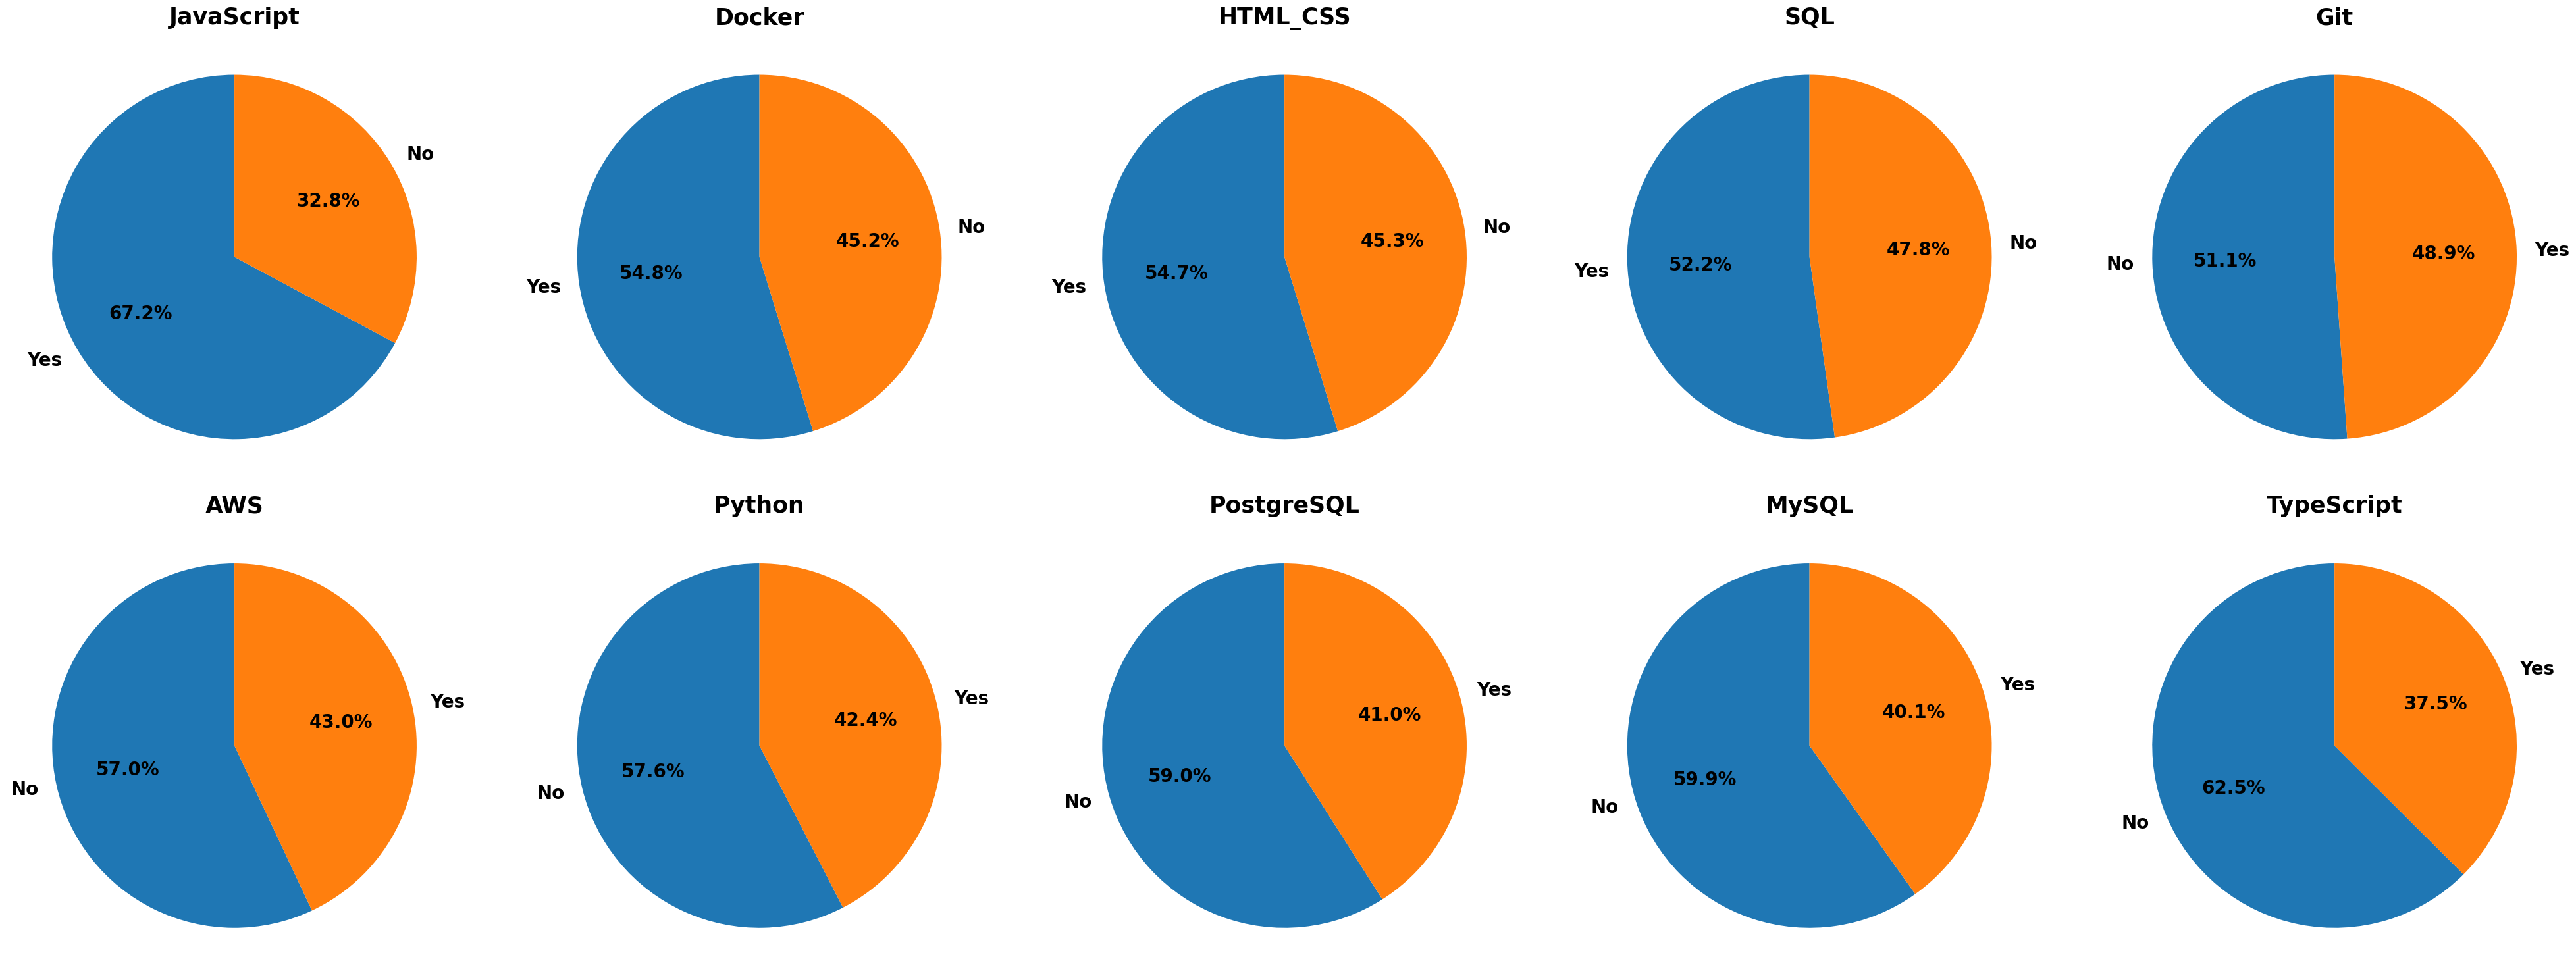

In [37]:
#distributions of coding languages
plot_all(df)

In [38]:
#This plot shows of the applicants who knew the language, what percent got accepted
def plot_acp(df):
    copy = df

    fig = plt.figure(figsize = (40, 15))

    plt.subplot(2,5,1)
    copy1 = copy[copy.JavaScript == 1]
    plt.pie(copy1.Employed.value_counts(), labels = ['Accepted', 'Not Accepted'], autopct = '%.1f%%', textprops = {'fontsize':20, 'fontweight':'bold'})
    plt.title('JavaScript - Accepted %', fontsize = 25, fontweight = 'bold')

    plt.subplot(2,5,2)
    copy2 = copy[copy.Docker == 1]
    plt.pie(copy2.Employed.value_counts(), labels = ['Accepted', 'Not Accepted'], autopct = '%.1f%%', textprops = {'fontsize':20, 'fontweight':'bold'})
    plt.title('Docker - Accepted %', fontsize = 25, fontweight = 'bold')

    plt.subplot(2,5,3)
    copy3 = copy[copy.HTML_CSS == 1]
    plt.pie(copy3.Employed.value_counts(), labels = ['Accepted', 'Not Accepted'], autopct = '%.1f%%', textprops = {'fontsize':20, 'fontweight':'bold'})
    plt.title('HTML_CSS - Accepted %', fontsize = 25, fontweight = 'bold')

    plt.subplot(2,5,4)
    copy4 = copy[copy.SQL == 1]
    plt.pie(copy4.Employed.value_counts(), labels = ['Accepted', 'Not Accepted'], autopct = '%.1f%%', textprops = {'fontsize':20, 'fontweight':'bold'})
    plt.title('SQL - Accepted %', fontsize = 25, fontweight = 'bold')

    plt.subplot(2,5,5)
    copy5 = copy[copy.Git == 1]
    plt.pie(copy5.Employed.value_counts(), labels = ['Accepted', 'Not Accepted'], autopct = '%.1f%%', textprops = {'fontsize':20, 'fontweight':'bold'})
    plt.title('Git - Accepted %', fontsize = 25, fontweight = 'bold')

    plt.subplot(2,5,6)
    copy6 = copy[copy.AWS == 1]
    plt.pie(copy6.Employed.value_counts(), labels = ['Accepted', 'Not Accepted'], autopct = '%.1f%%', textprops = {'fontsize':20, 'fontweight':'bold'})
    plt.title('AWS - Accepted %', fontsize = 25, fontweight = 'bold')

    plt.subplot(2,5,7)
    copy7 = copy[copy.Python == 1]
    plt.pie(copy7.Employed.value_counts(), labels = ['Accepted', 'Not Accepted'], autopct = '%.1f%%', textprops = {'fontsize':20, 'fontweight':'bold'})
    plt.title('Python - Accepted %', fontsize = 25, fontweight = 'bold')

    plt.subplot(2,5,8)
    copy8 = copy[copy.PostgreSQL == 1]
    plt.pie(copy8.Employed.value_counts(), labels = ['Accepted', 'Not Accepted'], autopct = '%.1f%%', textprops = {'fontsize':20, 'fontweight':'bold'})
    plt.title('PostgreSQL - Accepted %', fontsize = 25, fontweight = 'bold')

    plt.subplot(2,5,9)
    copy9 = copy[copy.MySQL == 1]
    plt.pie(copy9.Employed.value_counts(), labels = ['Accepted', 'Not Accepted'], autopct = '%.1f%%', textprops = {'fontsize':20, 'fontweight':'bold'})
    plt.title('MySQL - Accepted %', fontsize = 25, fontweight = 'bold')

    plt.subplot(2,5,10)
    copy10 = copy[copy.TypeScript == 1]
    plt.pie(copy10.Employed.value_counts(), labels = ['Accepted', 'Not Accepted'], autopct = '%.1f%%', textprops = {'fontsize':20, 'fontweight':'bold'})
    plt.title('TypeScript - Accepted %', fontsize = 25, fontweight = 'bold')

    plt.tight_layout()

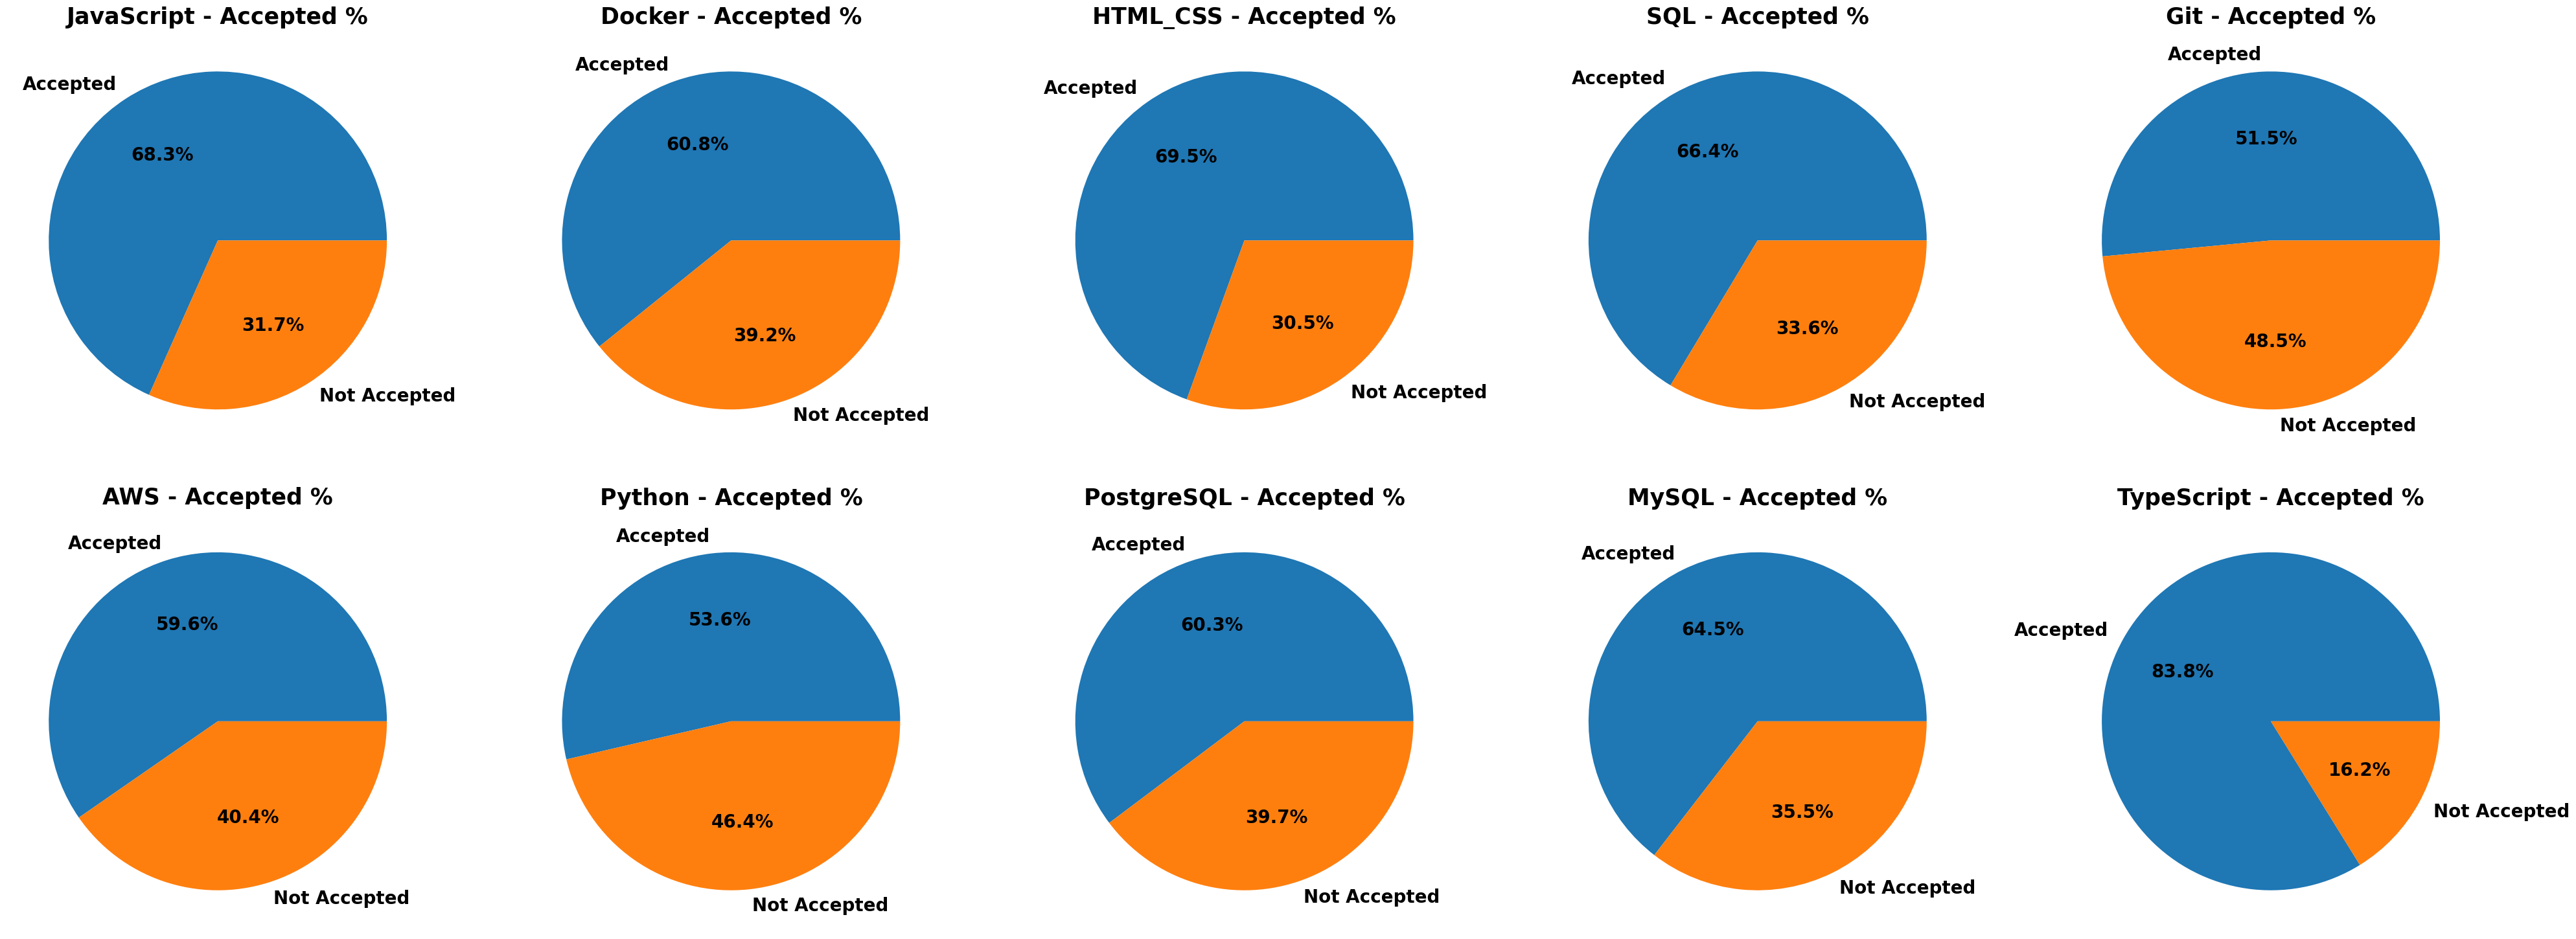

In [39]:
plot_acp(df)

In [40]:
def age_group(df):
    if df.Age == "<35":
        return "Under 35"
    else:
        return "Over 35"
df['age_group'] = df.apply(lambda df: age_group(df), axis = 1)

def emp_status(df):
    if df.Employed == 0:
        return "Employed"
    else:
        return "Unmployed"
df['Status'] = df.apply(lambda df: emp_status(df), axis = 1)

In [41]:
#creating function to exploring relationship between Employment and Variables
def paired_bar(df,var,title):
    sns.set(style = 'whitegrid')
    sns.set_context('paper', font_scale = 2)
    fig = plt.figure(figsize = (30,10))
    copy = df.copy()
    copy = copy.groupby(var)['Status'].value_counts().to_frame()
    copy = copy.rename({'Status':'pct_total'}, axis = 1).reset_index()
    copy['pct_total'] = (copy['pct_total']/len(df)) * 100
    a = sns.barplot(x=var, y = 'pct_total', hue = 'Status', data = copy)
    a.set_title(title, fontsize = 17, fontweight = 'bold')
    a.set_xticklabels(a.get_xticklabels(), rotation=30)
    a.set_ylabel('% of Applicants', fontweight = 'bold')

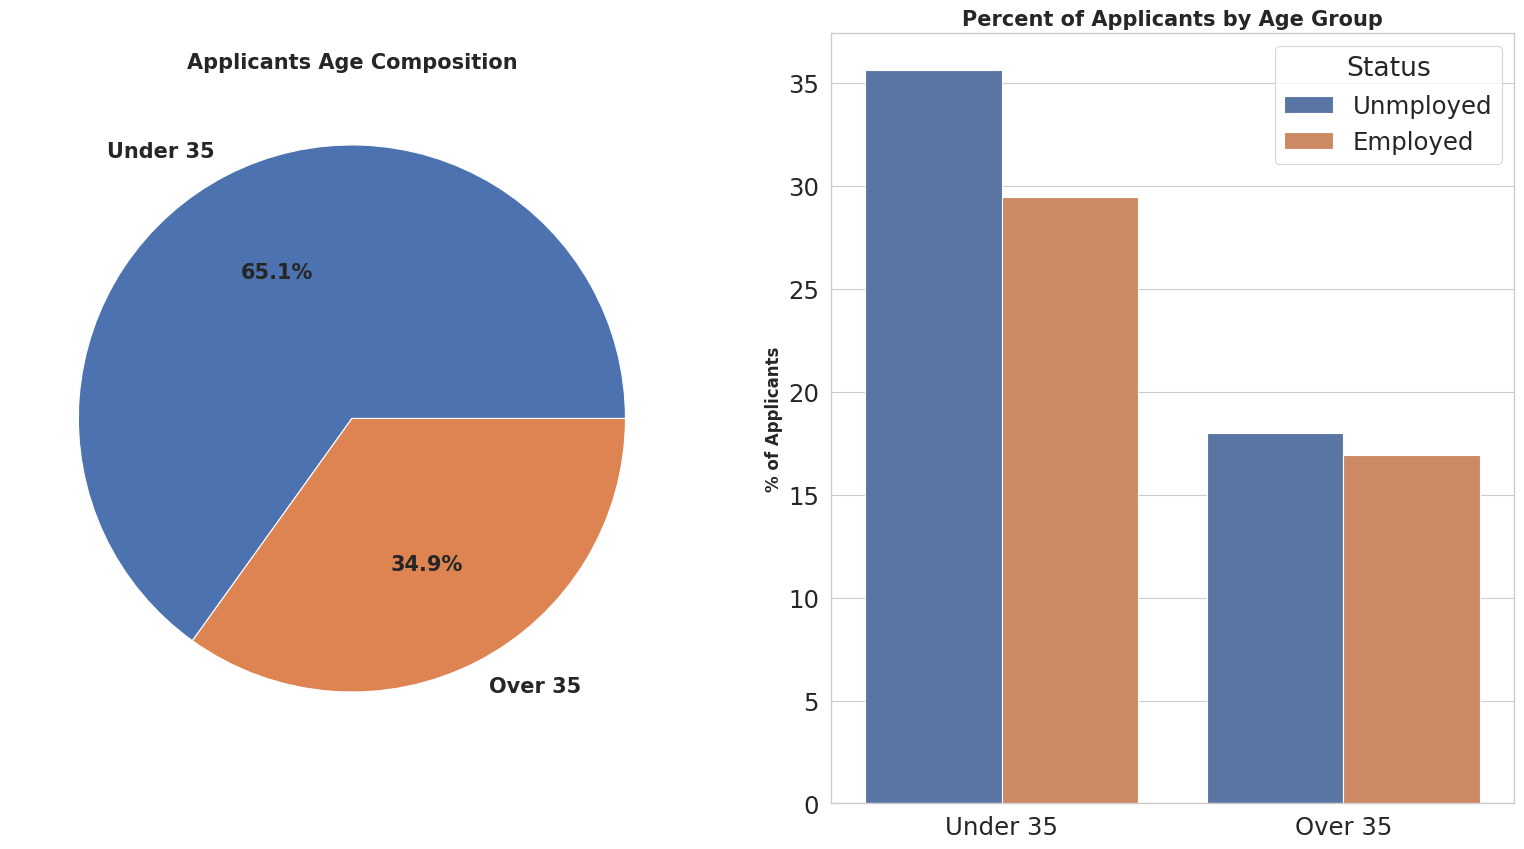

In [42]:
#creating function to exploring relationship between Employment and Age Group

def plot_age(df):
    sns.set(style = 'whitegrid')
    sns.set_context('paper', font_scale = 2)
    fig = plt.figure(figsize = (30,10))

    plt.subplot(131)
    plt.pie(df.age_group.value_counts(), labels = ['Under 35','Over 35'], radius = 1,autopct = '%.1f%%', textprops = {'fontsize':15, 'fontweight':'bold'})
    plt.title('Applicants Age Composition', fontweight = 'bold', fontsize = 15)

    plt.subplot(132)
    copy = df.copy()
    copy = copy.groupby('age_group')['Status'].value_counts().to_frame()
    copy = copy.loc[['Under 35', 'Over 35']]
    copy = copy.rename({'Status':'pct_total'}, axis = 1).reset_index()
    copy['pct_total'] = (copy['pct_total']/len(df)) * 100
    a = sns.barplot(data = copy, x= 'age_group', y = 'pct_total', hue = 'Status')
    a.set_title('Percent of Applicants by Age Group', fontsize = 15, fontweight = 'bold')
    #a.set_xticklabels(a.get_xticklabels())
    a.set_ylabel('% of Applicants', fontweight = 'bold', fontsize = 12)
    a.set_xlabel('', fontweight = 'bold', fontsize = 12)

plot_age(df)

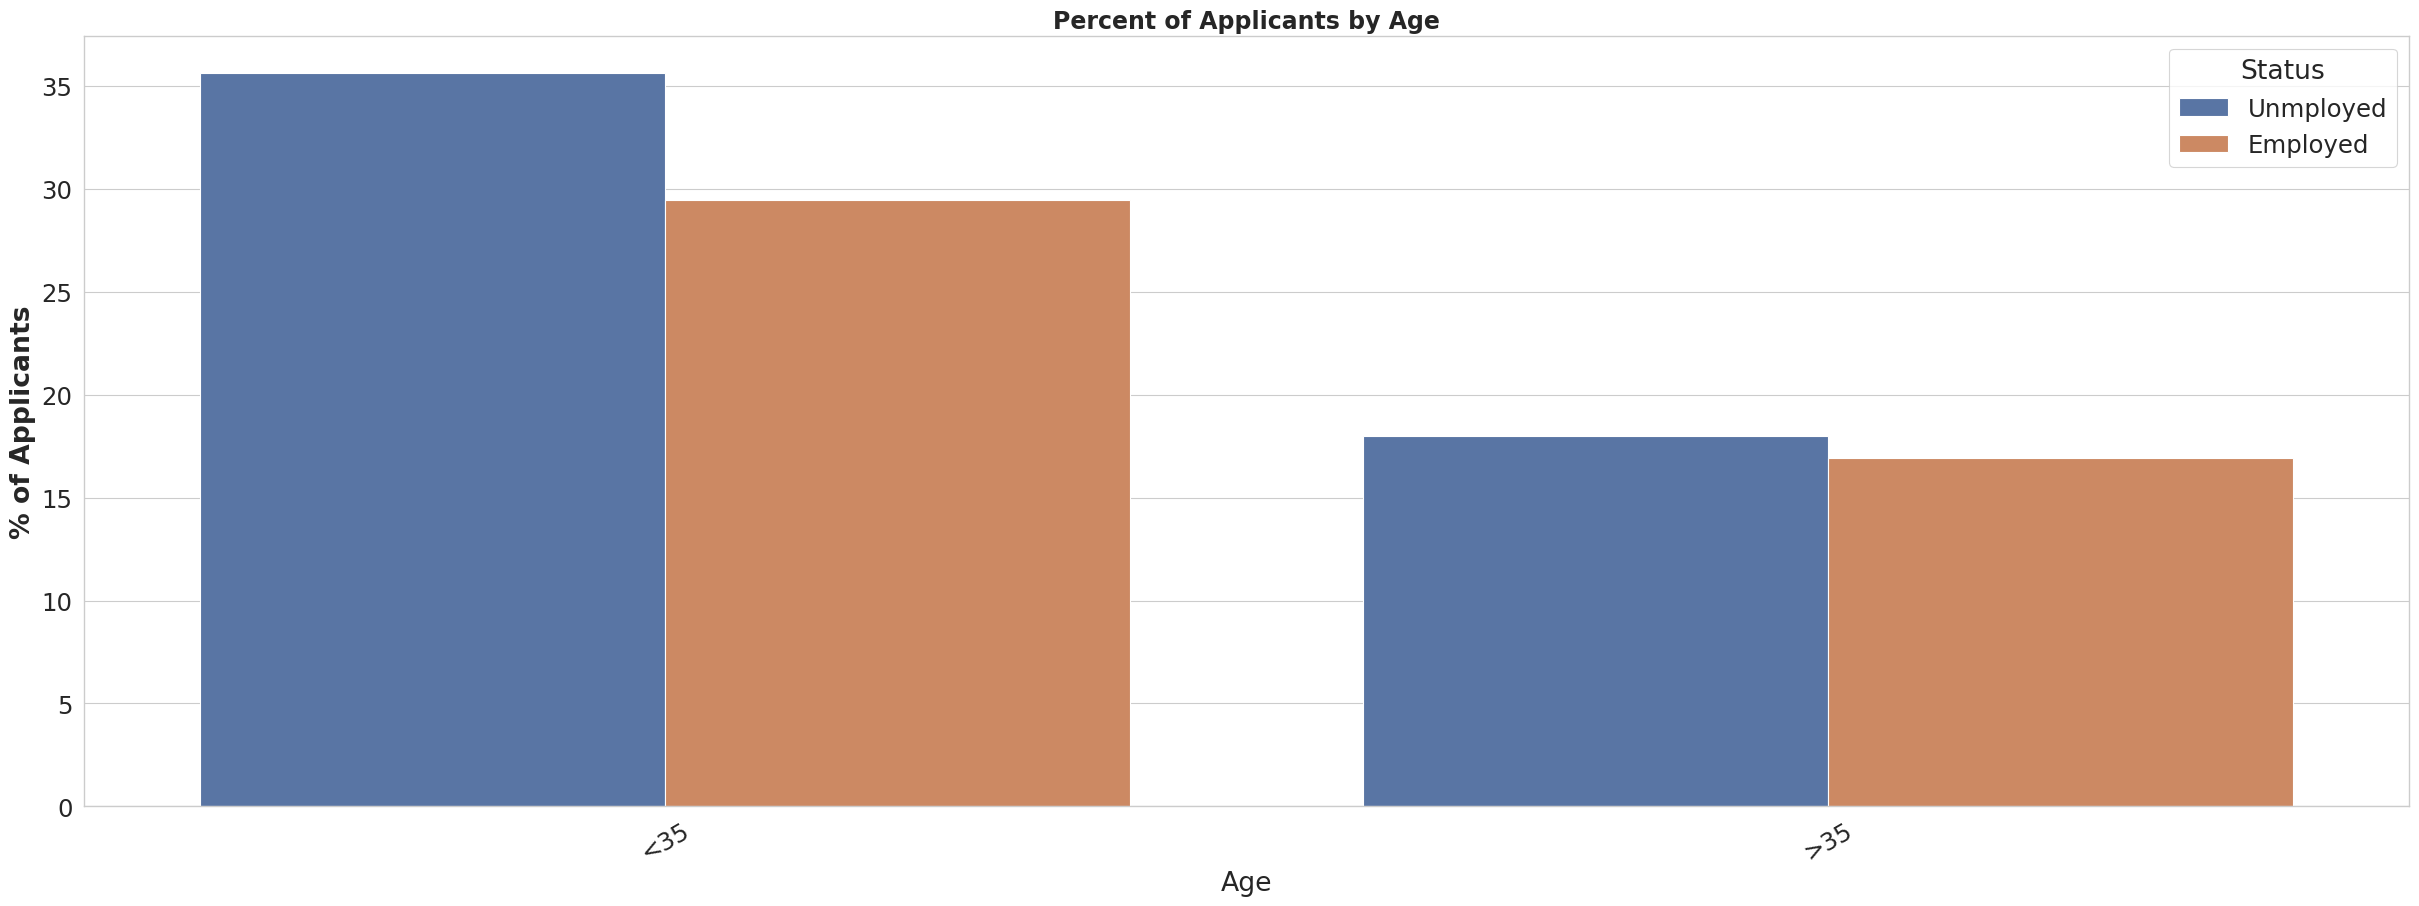

In [43]:
#age
paired_bar(df=df,var='Age', title='Percent of Applicants by Age')

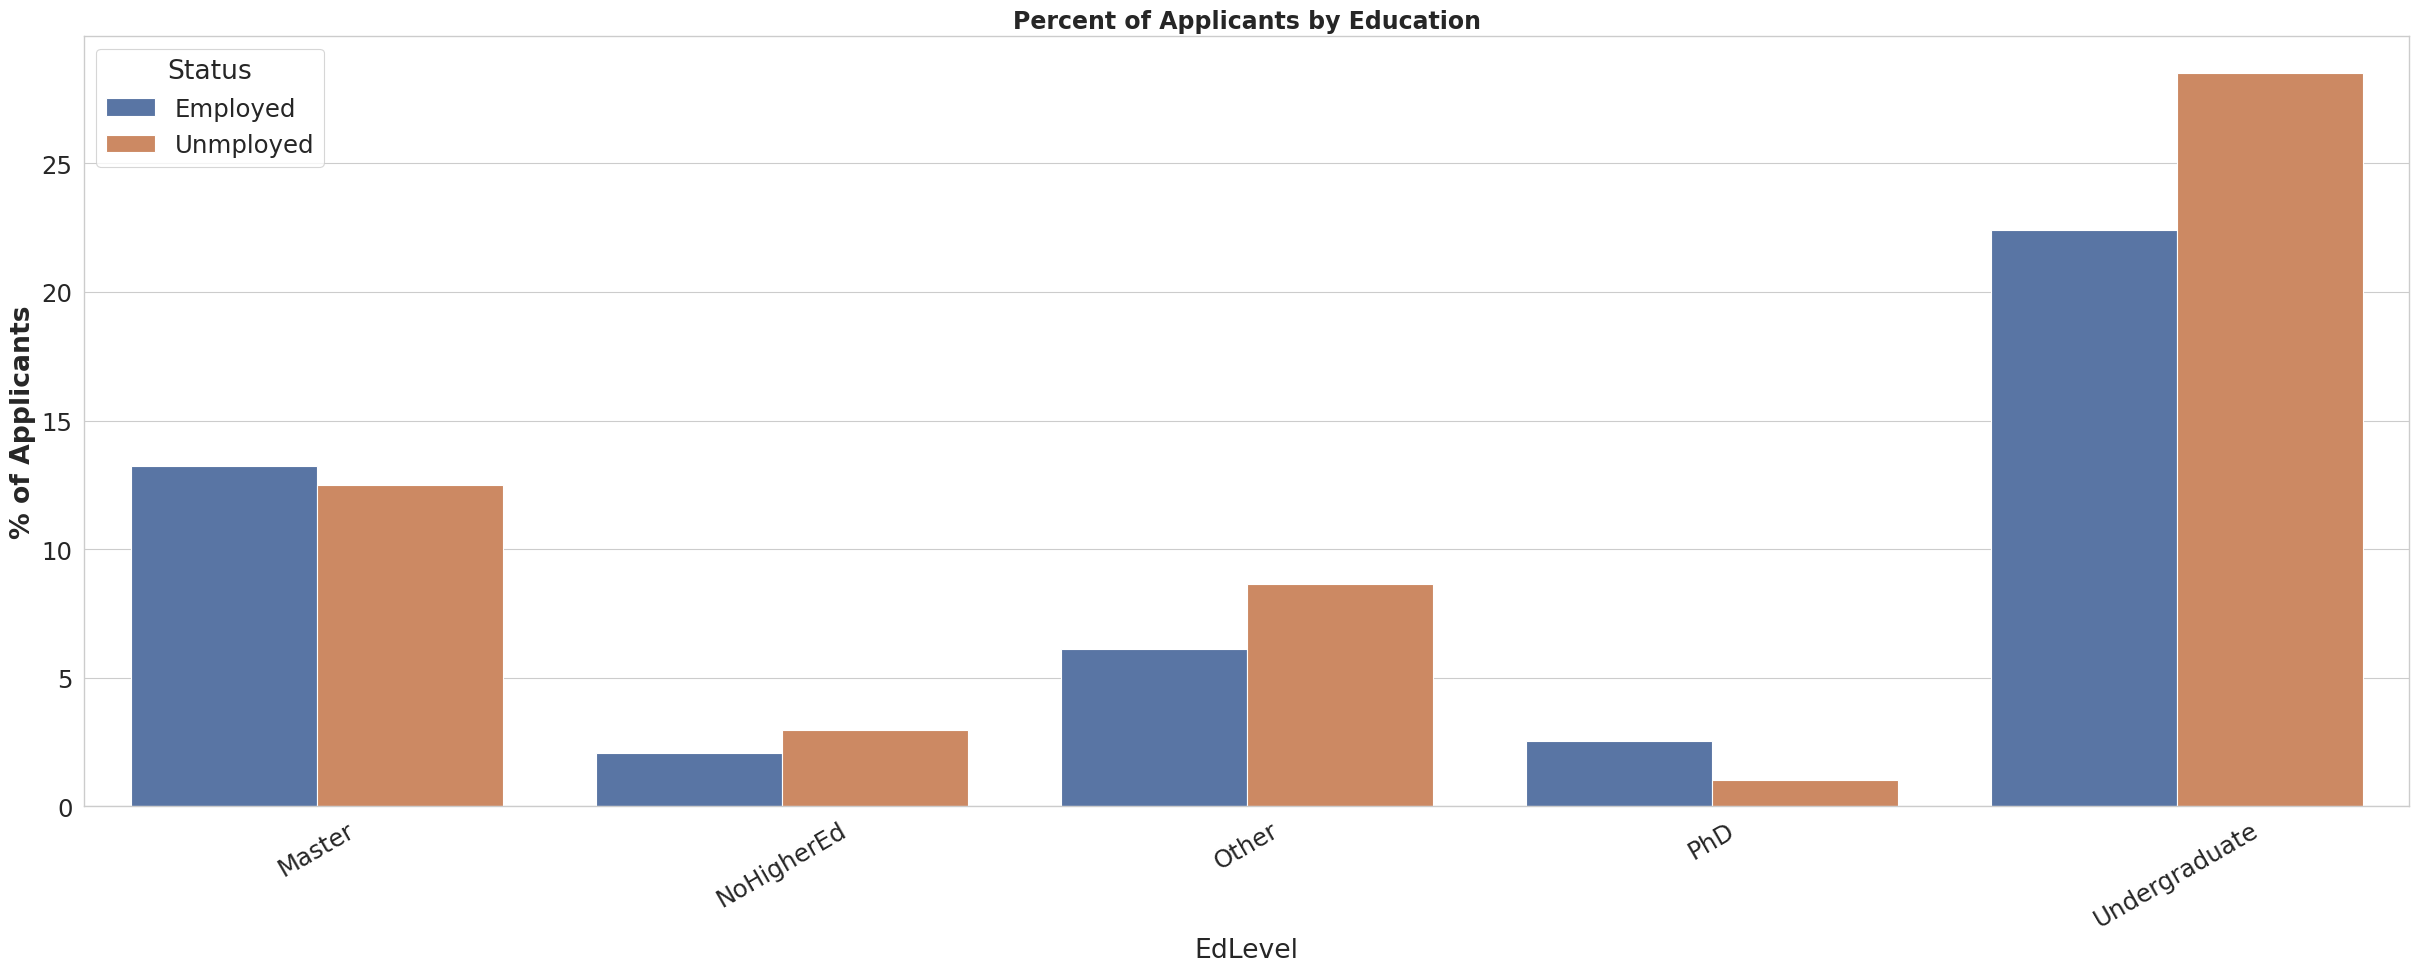

In [44]:
#education
paired_bar(df=df,var='EdLevel', title='Percent of Applicants by Education')

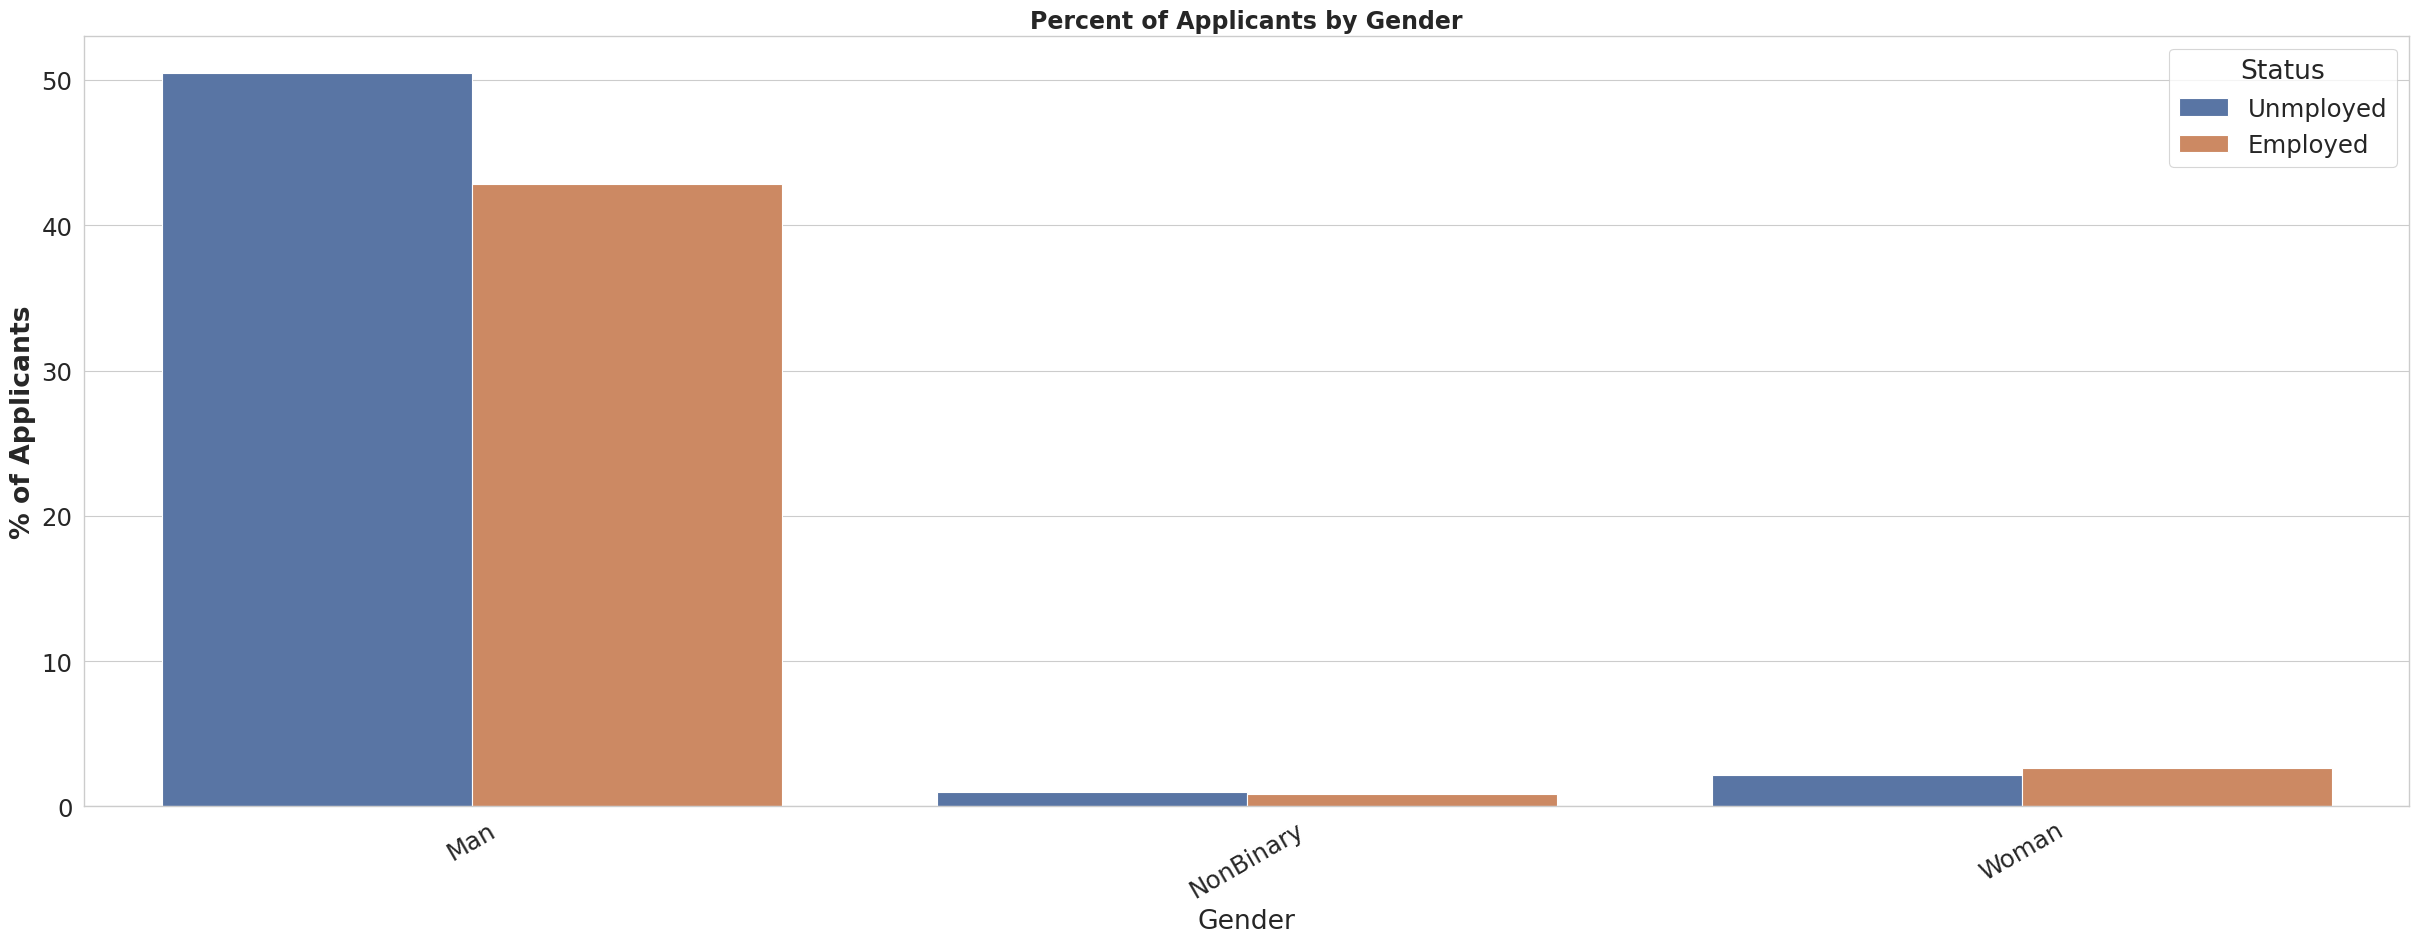

In [45]:
#gender
paired_bar(df=df,var='Gender', title='Percent of Applicants by Gender')

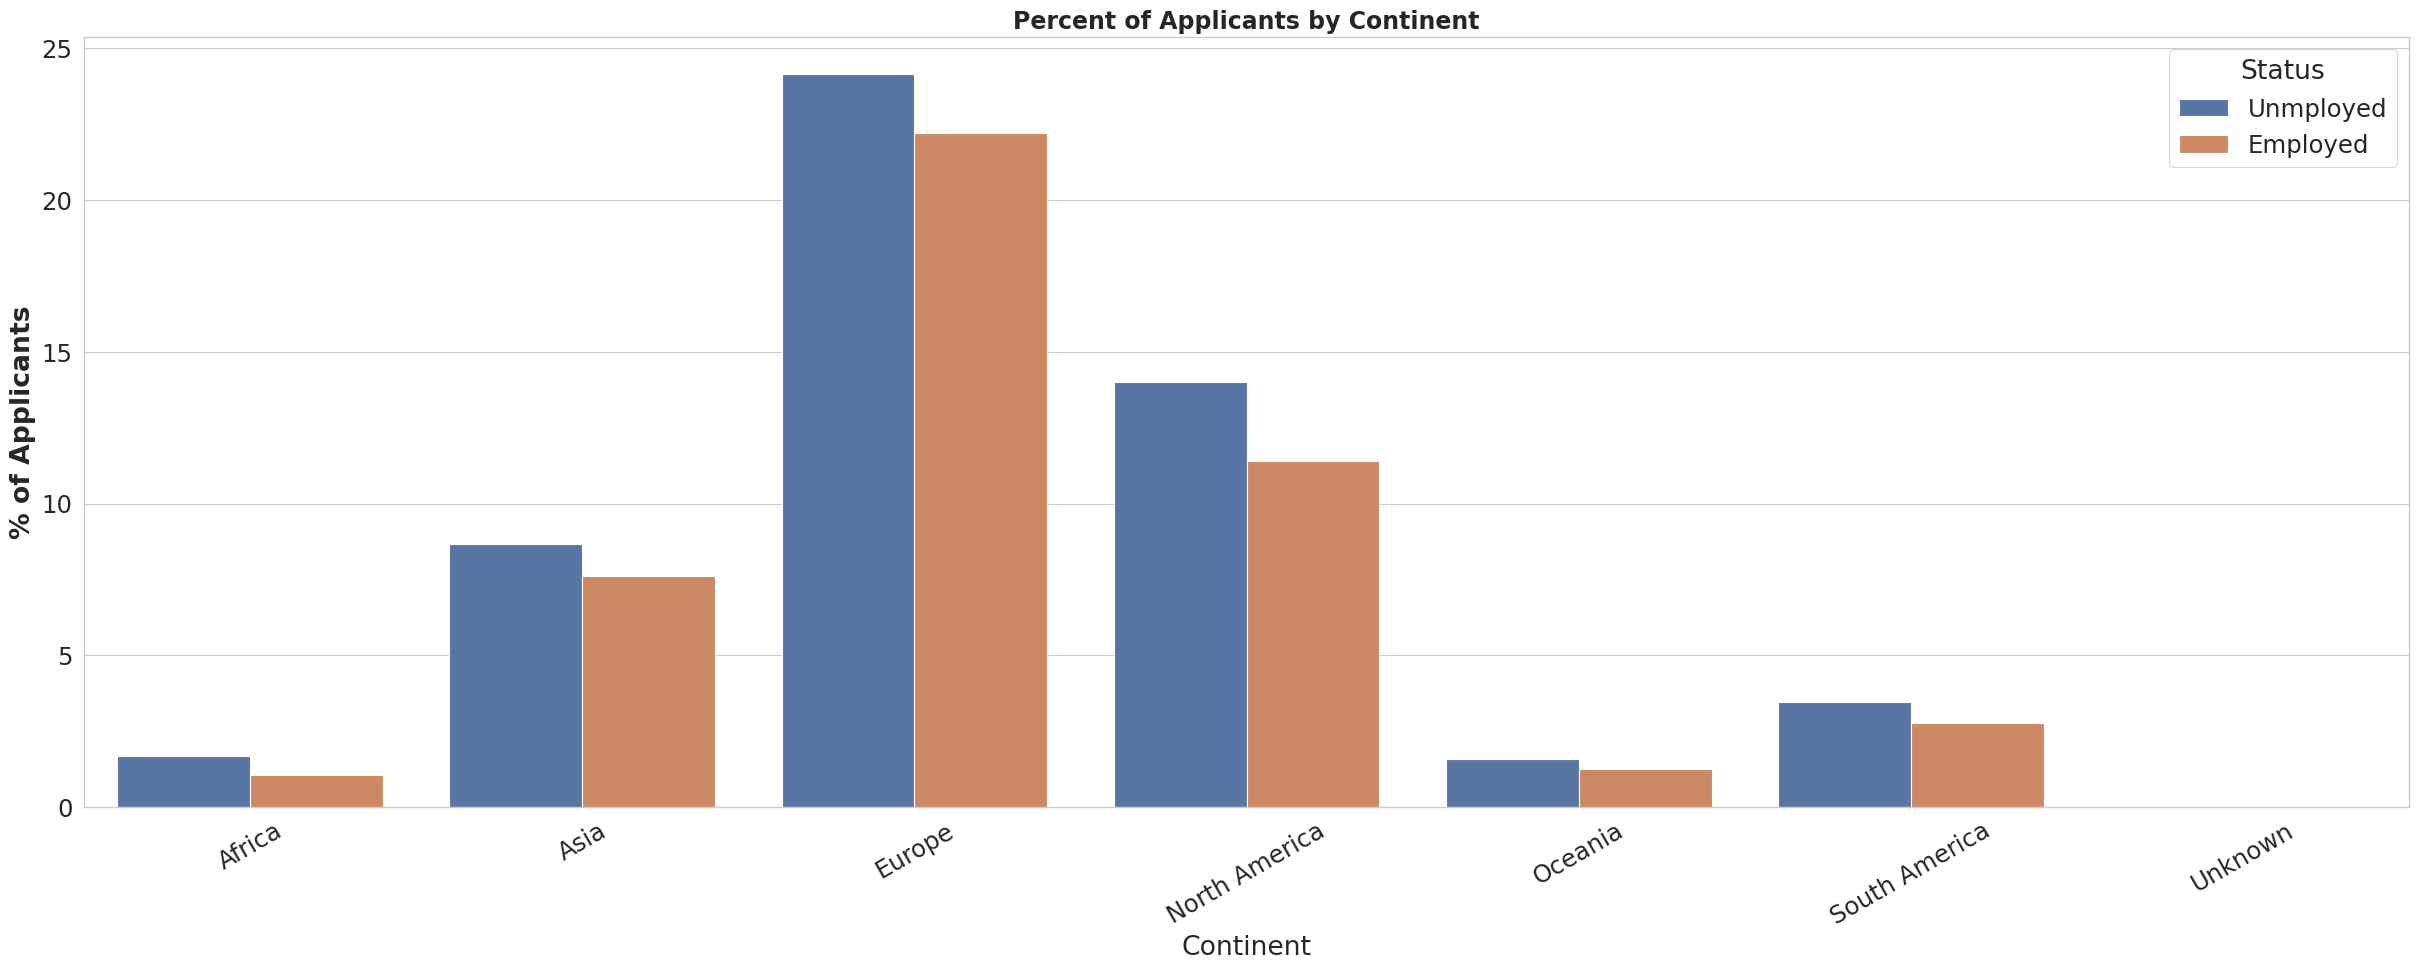

In [46]:
#continent
paired_bar(df=df,var='Continent', title='Percent of Applicants by Continent')

Text(0.5, 0, 'Number of Computer Skills/Languages')

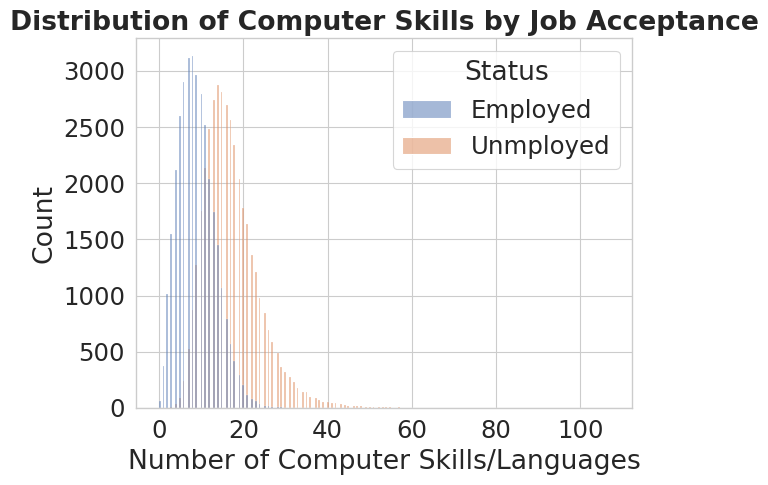

In [47]:
#amount of computer skills
a= sns.histplot(data=df, x="ComputerSkills", hue="Status")
a.set_title('Distribution of Computer Skills by Job Acceptance', fontweight = 'bold')
a.set_xlabel('Number of Computer Skills/Languages')

## Machine Learning Algorithms

In [48]:
# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .25, random_state = 46)

In [49]:
# logistic regression with report
lr_classifier = LogisticRegression(fit_intercept=False, solver='liblinear')
lr_classifier.fit(X_train, y_train)
lr_predictions = lr_classifier.predict(X_test)
lr_accuracy = accuracy_score(y_test, lr_predictions)
lr_report = classification_report(y_test, lr_predictions)

print(lr_report)

              precision    recall  f1-score   support

           0       0.82      0.74      0.78      8529
           1       0.79      0.86      0.83      9837

    accuracy                           0.80     18366
   macro avg       0.81      0.80      0.80     18366
weighted avg       0.81      0.80      0.80     18366



In [50]:
# decision tree with report
dt_classifier = DecisionTreeClassifier()
dt_classifier.fit(X_train, y_train)
dt_predictions = dt_classifier.predict(X_test)
dt_accuracy = accuracy_score(y_test, dt_predictions)
dt_report = classification_report(y_test, dt_predictions)

print(dt_report)

              precision    recall  f1-score   support

           0       0.75      0.75      0.75      8529
           1       0.78      0.78      0.78      9837

    accuracy                           0.77     18366
   macro avg       0.77      0.77      0.77     18366
weighted avg       0.77      0.77      0.77     18366



In [51]:
# K nearest neighbors with report
knn_classifier = KNeighborsClassifier(n_neighbors = 5)
knn_classifier.fit(X_train, y_train)
knn_predictions = knn_classifier.predict(X_test)
knn_accuracy = accuracy_score(y_test, knn_predictions)
knn_report = classification_report(y_test, knn_predictions)

print(knn_report)

              precision    recall  f1-score   support

           0       0.67      0.64      0.66      8529
           1       0.70      0.72      0.71      9837

    accuracy                           0.69     18366
   macro avg       0.68      0.68      0.68     18366
weighted avg       0.68      0.69      0.69     18366



In [52]:
# Random Forest with report
rf_classifier = RandomForestClassifier()
rf_classifier.fit(X_train, y_train)
rf_predictions = rf_classifier.predict(X_test)
rf_accuracy = accuracy_score(y_test, rf_predictions)
rf_report = classification_report(y_test, rf_predictions)

print(rf_report)

              precision    recall  f1-score   support

           0       0.83      0.81      0.82      8529
           1       0.84      0.85      0.84      9837

    accuracy                           0.83     18366
   macro avg       0.83      0.83      0.83     18366
weighted avg       0.83      0.83      0.83     18366



In [53]:
precisionlr = precision_score(y_test, lr_predictions, average='macro')
precisiondt = precision_score(y_test, dt_predictions, average='macro')
precisionknn = precision_score(y_test, knn_predictions, average='macro')
precisionrf = precision_score(y_test, rf_predictions, average='macro')

print("LR precision:",precisionlr)
print("DT precision:",precisiondt)
print("KNN precision:",precisionknn)
print("RF precision:",precisionrf)

LR precision: 0.8074814962334116
DT precision: 0.7668621642709552
KNN precision: 0.683733642324043
RF precision: 0.8318952563311417


In [54]:
recalllr = recall_score(y_test, lr_predictions, average='macro')
recalldt = recall_score(y_test, dt_predictions, average='macro')
recallknn = recall_score(y_test, knn_predictions, average='macro')
recallrf = recall_score(y_test, rf_predictions, average='macro')

print("LR recall:",recallrf)
print("DT recall:",recalldt)
print("KNN recall:",recallknn)
print("RF recall:",recallrf)

LR recall: 0.8308751681604669
DT recall: 0.7669841132943233
KNN recall: 0.6826980628421963
RF recall: 0.8308751681604669


In [55]:
# F1 scores comparison
f1lr=f1_score(y_test, lr_predictions,average='macro')
f1dt=f1_score(y_test, dt_predictions,average='macro')
f1knn=f1_score(y_test, knn_predictions,average='macro')
f1rf=f1_score(y_test, rf_predictions,average='macro')

print("lR F1 Score:",f1lr)
print("DT F1 Score:",f1dt)
print("KNN F1 Score:",f1knn)
print("RF F1 Score",f1rf)

lR F1 Score: 0.8021992759352882
DT F1 Score: 0.7669210686168862
KNN F1 Score: 0.6830367687944112
RF F1 Score 0.8313093154026034


Test Confusion matrix


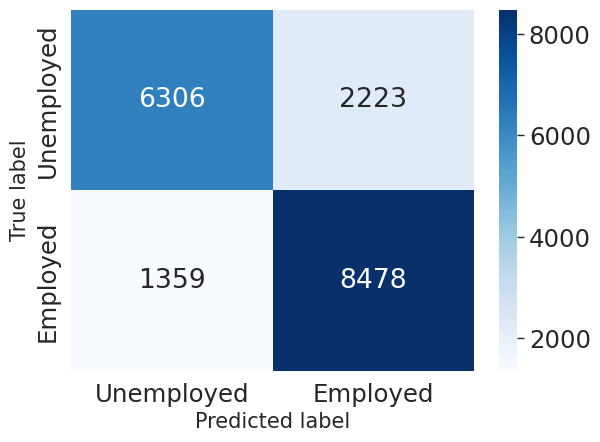

In [56]:
# visualizing a confusion matrix using the logistic regression model
classes=['Unemployed', 'Employed']
def plot_confusionmatrix(y_train_pred,y_train,dom, classes):
    print(f'{dom} Confusion matrix')
    cf = confusion_matrix(y_train,y_train_pred)
    sns.heatmap(cf,annot=True,yticklabels=classes
               ,xticklabels=classes,cmap='Blues', fmt='g')
    plt.ylabel("True label", fontsize = 15)
    plt.xlabel("Predicted label", fontsize = 15)
    plt.tight_layout()
    plt.show()

plot_confusionmatrix(lr_predictions, y_test, dom = "Test", classes = classes)

In [57]:
#Plot AUC to obtain both the roc curve for the training dataset and the testing

def plot_auc(model, X_train, X_test, y_train, y_test):

    # Calculate probability score of each point in training set
    y_train_score = model.decision_function(X_train)
    # Calculate false positive rate, true positive rate, and thresholds for training set
    train_fpr, train_tpr, train_thresholds = roc_curve(y_train, y_train_score)
    # Calculate probability score of each point in test set
    y_test_score = model.decision_function(X_test)
    # Calculate false positive rate, true positive rate, and thresholds for test set
    test_fpr, test_tpr, test_thresholds = roc_curve(y_test, y_test_score)

    # Print Area-Under-Curve scores
    print('Training AUC: {}'.format(auc(train_fpr, train_tpr)))
    print('Test AUC: {}'.format(auc(test_fpr, test_tpr)))

    plt.figure(figsize = (30, 10))
    lw = 4

    # Use Train False/True Positive ratios to plot receiver operating characteristic curve for training set
    plt.subplot(121)
    plt.plot(train_fpr, train_tpr, color = 'red', lw = lw, label = 'ROC Curve')
    # Plot positive line w/ slope = 1 for ROC-curve reference
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.yticks([i/20.0 for i in range(21)])
    plt.xticks([i/20.0 for i in range(21)])
    plt.xlabel('False Positive Rate', fontsize = 20, fontweight = 'bold')
    plt.ylabel('True Positive Rate', fontsize = 20, fontweight = 'bold')
    plt.title('Receiver operating characteristic (ROC) Curve for Training Set', fontweight = 'bold', fontsize = 20)
    plt.legend(loc='lower right')

    # Use Test False/True positive ratios to plot receiver operating characteristic curve for test set
    plt.subplot(122)
    plt.plot(test_fpr, test_tpr, color='red',
         lw=lw, label='ROC curve')
    # Plot positive line w/ slope = 1 for ROC-curve reference
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.yticks([i/20.0 for i in range(21)])
    plt.xticks([i/20.0 for i in range(21)])
    plt.xlabel('False Positive Rate', fontweight = 'bold', fontsize = 20)
    plt.ylabel('True Positive Rate', fontweight = 'bold', fontsize = 20)
    plt.title('Receiver operating characteristic (ROC) Curve for Test Set', fontweight = 'bold', fontsize = 20)
    plt.legend(loc='lower right')

    #plt.savefig('pics/Regression_pics/roc_curve.png')

    plt.tight_layout()

Training AUC: 0.8897571113630225
Test AUC: 0.8902573788846841


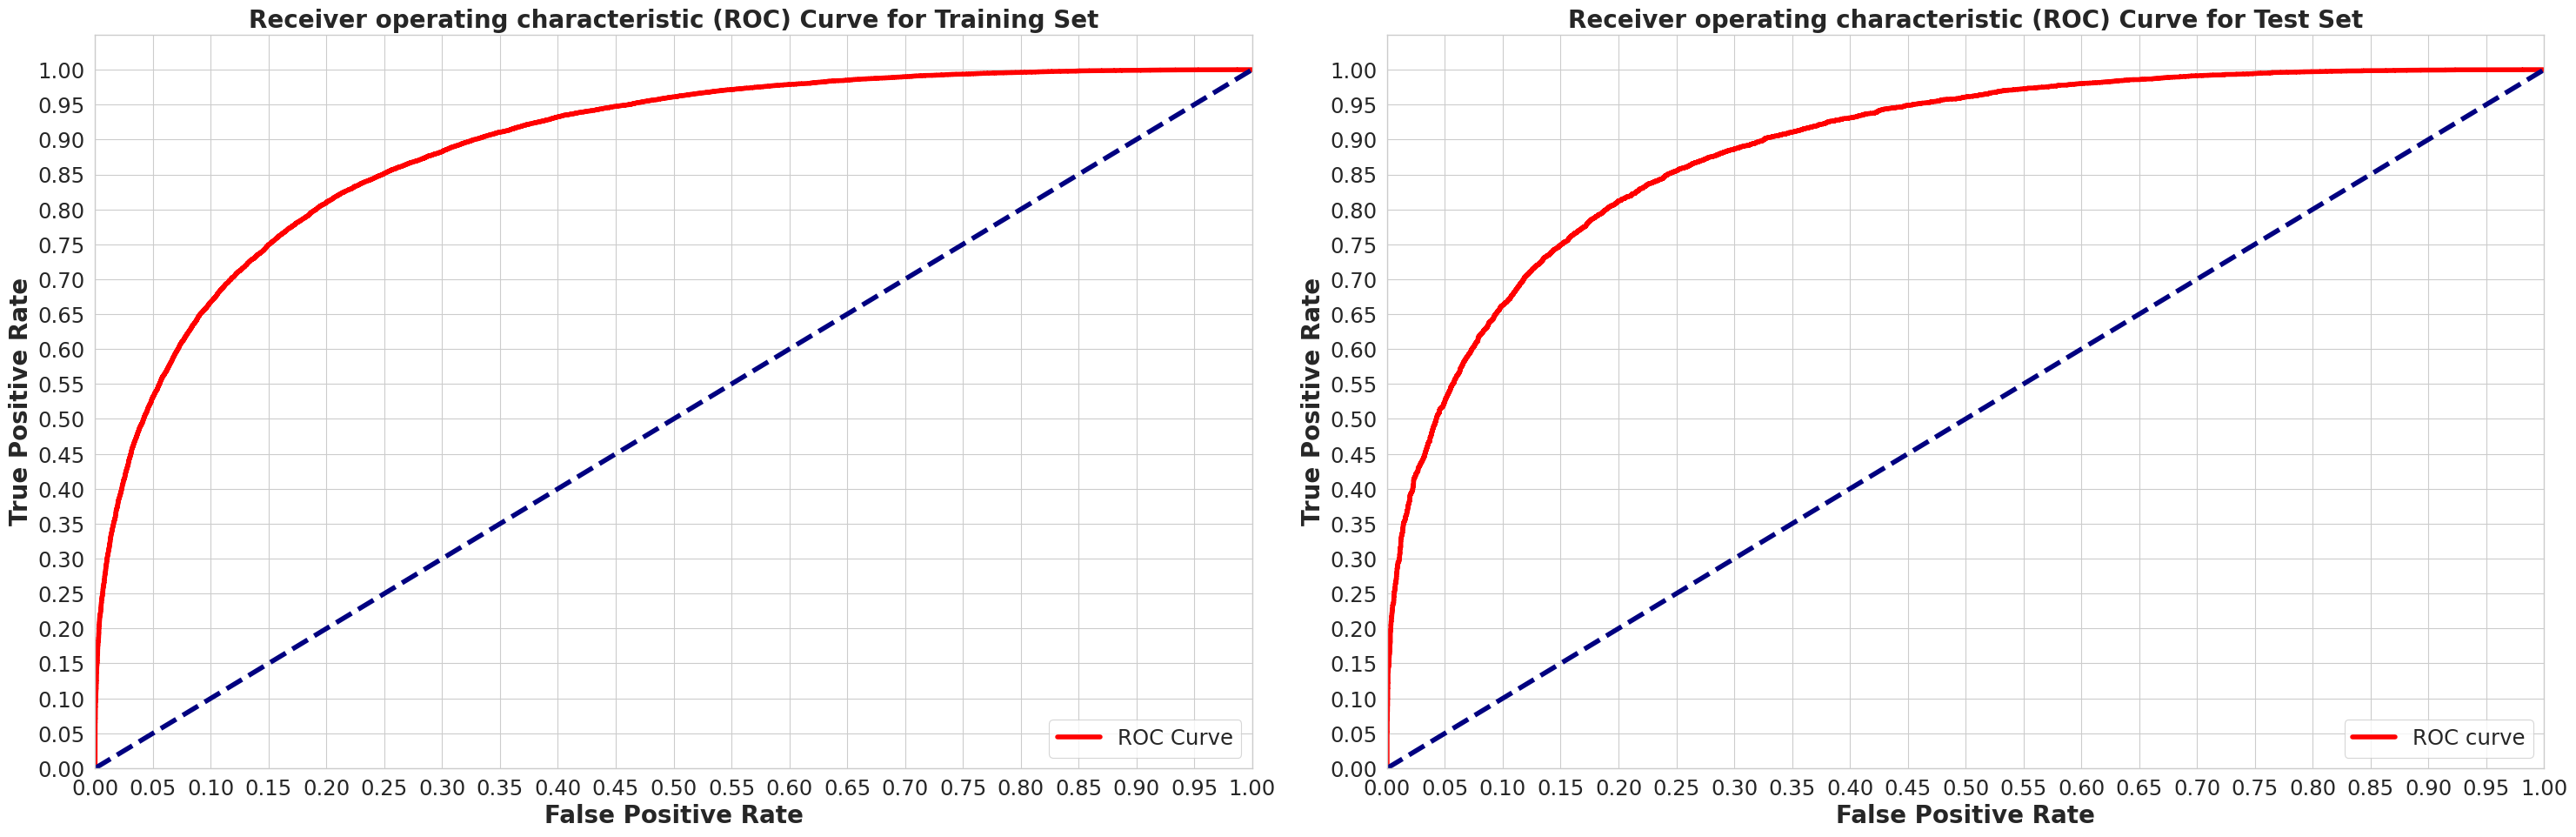

In [58]:
plot_auc(lr_classifier, X_train, X_test, y_train, y_test)


In [59]:
param_grid_short = {
    'n_estimators': [100, 150, 200, 250, 300],
    'max_depth': [ 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2'],
}

In [60]:
from sklearn.model_selection import RandomizedSearchCV

In [61]:
clf = RandomForestClassifier(n_estimators=100, random_state=0)

rm_search = RandomizedSearchCV(clf,param_grid_short, cv=5, scoring='accuracy')
rm_search.fit(X_train, y_train)

# Use the best model to predict on the testing dataset
best_model = rm_search.best_estimator_
y_pred_cv = best_model.predict(X_test)

# Evaluate the model using a classification report
report = classification_report(y_test, y_pred_cv)
print("Classification Report:\n", report)

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomFor

Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.80      0.82      8529
           1       0.83      0.86      0.85      9837

    accuracy                           0.83     18366
   macro avg       0.83      0.83      0.83     18366
weighted avg       0.83      0.83      0.83     18366



In [62]:
rm_search.best_params_

{'n_estimators': 250,
 'min_samples_split': 10,
 'min_samples_leaf': 4,
 'max_features': 'log2',
 'max_depth': 20}

In [63]:
feature_names = X_train.columns

In [64]:
#running the top model
rnd_clf = RandomForestClassifier(n_estimators=300, min_samples_split=10, max_depth=20, max_features='auto', min_samples_leaf=1, random_state=0)
model = rnd_clf.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


In [65]:
#viewing the results
for name, importance in zip(feature_names, rnd_clf.feature_importances_):
     print(name, "=", importance)

Employment = 0.006650622801363422
YearsCode = 0.043527846006844
YearsCodePro = 0.0405860120804901
PreviousSalary = 0.05907205837523321
ComputerSkills = 0.3622015050850519
Age_<35 = 0.006779185126671495
Accessibility_Yes = 0.0032911801348552375
EdLevel_Master = 0.006446690696537718
EdLevel_NoHigherEd = 0.004225271916496838
EdLevel_PhD = 0.003666436093479905
EdLevel_Undergraduate = 0.00709317153292412
Gender_Man = 0.004472212952395697
Gender_Woman = 0.003554860236692615
MentalHealth_Yes = 0.0075828602173681914
MainBranch_Dev = 0.006894754023098078
Continent_Africa = 0.0028159853663106975
Continent_Asia = 0.005507102636406187
Continent_Europe = 0.006656436912121127
Continent_North America = 0.006129283671069714
Continent_Oceania = 0.003032293059277655
Continent_South America = 0.004541286630395873
JavaScript = 0.08329063165680504
Docker = 0.015679693188254785
HTML_CSS = 0.04296699505842945
SQL = 0.03471147230934943
Git = 0.015238660846340792
AWS = 0.013868198047107965
Python = 0.012643170

In [66]:
#saving the results to a df
resultsdf = pd.DataFrame()
for name, importance in zip(feature_names, rnd_clf.feature_importances_):
    resultsdf = resultsdf.append({'featureName': name, 'featureImportance': importance}, ignore_index=True)


<ipython-input-66-3ae7dc883153>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  resultsdf = resultsdf.append({'featureName': name, 'featureImportance': importance}, ignore_index=True)
<ipython-input-66-3ae7dc883153>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  resultsdf = resultsdf.append({'featureName': name, 'featureImportance': importance}, ignore_index=True)
<ipython-input-66-3ae7dc883153>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  resultsdf = resultsdf.append({'featureName': name, 'featureImportance': importance}, ignore_index=True)
<ipython-input-66-3ae7dc883153>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  resultsd

In [67]:
#checking results
resultsdf.head()

,featureName,featureImportance
0,Employment,0.006651
1,YearsCode,0.043528
2,YearsCodePro,0.040586
3,PreviousSalary,0.059072
4,ComputerSkills,0.362202


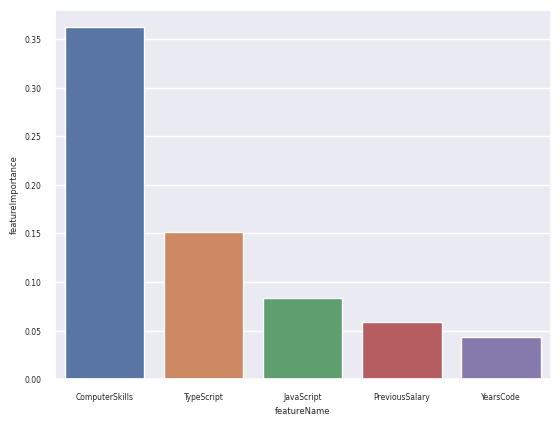

In [71]:
#visualizing results
sns.barplot(
    x='featureName',
    y='featureImportance',
    data=resultsdf.nlargest(5, 'featureImportance')
)

sns.set(font_scale=1)

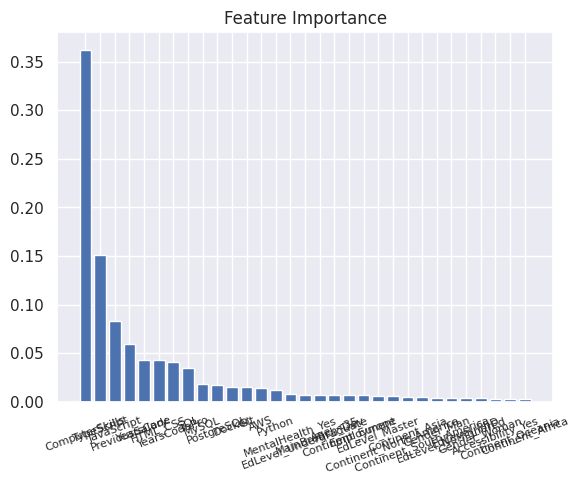

In [72]:

#another way to see important features
#shows all, IDK how to limit to top 5

# Calculate feature importances
importances = model.feature_importances_
# Sort feature importances in descending order
indices = np.argsort(importances)[::-1]

# Rearrange feature names so they match the sorted feature importances
names = [feature_names[i] for i in indices]

# Barplot: Add bars
plt.bar(range(X_train.shape[1]), importances[indices])
# Add feature names as x-axis labels
plt.xticks(range(X_train.shape[1]), names, rotation=20, fontsize = 8)
# Create plot title
plt.title("Feature Importance")
# Show plot
plt.show()